#Below, we have used a Le-net architecture CNN Network on MNIST Dataset.

Importing the required Libraries

In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split

Importing data.

In [59]:
import torchvision
import torchvision.transforms as transforms
trainset=torchvision.datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
testset=torchvision.datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

In [61]:
classes_tr=trainset.classes
train=trainset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
classes_test=testset.classes
test=testset
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

Visualising the dataset, by visualising images.

In [48]:
dataiter=iter(trainloader)

images, labels= dataiter.next()
print(images.shape,labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [49]:
npimg=images.detach().numpy()
npimg2=np.transpose(npimg[3],(1,2,0))
npimg2=npimg2.reshape(28,28)                #When printing a white_black image, we have a 2d array rather a 3d. But, for a RBG, we use 3d array.

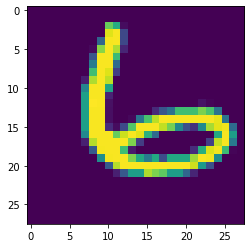

In [50]:
plt.imshow(npimg2)

#Convolutional Neural Network.
Below, we have have implemented a Le-net Architecture.
But, as **MNIST Dataset** is a black-white dataset, I had made some changes accordingly.


In [51]:
class cov_net(nn.Module):
  def __init__(self):
    super(cov_net,self).__init__()
    self.cnn_net=nn.Sequential(
        nn.Conv2d(1,6,5),                           #(N,1,28,28)-->(N,6,24,24)      
        nn.Tanh(),
        nn.MaxPool2d(2,stride=2),                   #(N,6,24,24)-->(N,6,12,12)              
        nn.Conv2d(6,16,5),                          #(N,6,12,12)-->(N,16,8,8)
        nn.Tanh(),
        nn.MaxPool2d(2,2)                           #(N,16,8,8)-->(N,16,4,4)-->(after flattening)-->(N,256)
    )
    self.fcc_net=nn.Sequential(
        nn.Linear(256,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,10),
        nn.Tanh()
    )

  def feed_forward(self,x):
    x = self.cnn_net(x)
    x=x.view(x.size(0),-1)                         #preserve the first shape output, and colapse the rest into a single column vector.
    x = self.fcc_net(x)

    return x

In [52]:
def evaluation_gpu(dataloader):
  total=0
  correct=0
  for data in dataloader:
    inputs,labels=data
    inputs,labels=inputs.to(device), labels.to(device)
    output=net.feed_forward(inputs)
    a , pred=torch.max(output.data,1)
    total+=labels.size(0)
    correct+=(pred==labels).sum().item()

  return (correct/total)*100

In [53]:
%%time
def fit_gpu(trainloader,epochs,model,op,loss_fn):
  loss_tr=[]
  loss_val=[]
  acc=[]
  for i in tqdm_notebook(range(epochs), total=epochs, unit='epochs'):
    for i,data in enumerate(trainloader,0):
      inputs, labels=data
      inputs , labels= inputs.to(device) , labels.to(device)

      inpt_train,inpt_val,lab_train,lab_val = train_test_split(inputs,labels)
      op.zero_grad()
      
      out_tr=net.feed_forward(inpt_train)
      

      l=loss_fn(out_tr,lab_train)
      l.backward()

      op.step()

    loss_tr.append(l.item())
    
    out_val=net.feed_forward(inpt_val)
    l_val=loss_fn(out_val,lab_val)
    loss_val.append(l_val)

    acc.append(evaluation_gpu(trainloader))
  
  fig,ax = plt.subplots()
  color='tab:red'
  ax.set_ylabel('loss',color=color)
  ax.set_xlabel('epochs')
  ax.plot(loss_tr,color=color)
  ax.plot(loss_val,color='b')
  plt.show()

  return acc
    

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [149]:
device=torch.device('cuda:0')
net=cov_net().to(device)
loss_fn=nn.CrossEntropyLoss()
op=opt.Adam(net.parameters(),lr=0.00025)


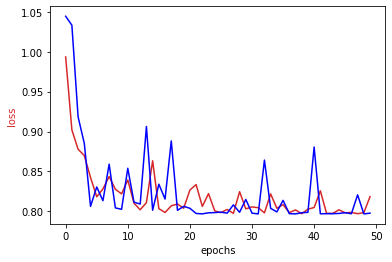

CPU times: user 8min 5s, sys: 3.14 s, total: 8min 8s
Wall time: 8min 9s


In [150]:
%%time
acc=fit_gpu(trainloader,50,net,op,loss_fn)

The red is the **training loss**, while the blue is the **validation loss**.

In [151]:
print(('Train accuracy is : {:.2f}').format(evaluation_gpu(trainloader)))
print(('Test accuracy is :{:.2f}').format(evaluation_gpu(testloader)))

Train accuracy is : 99.78
Test accuracy is :99.00


# Visualisation of the output images.

In [152]:
net=net.to('cpu')
out=net.feed_forward(images)

In [153]:
net.cnn_net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [154]:
out=net.cnn_net[1]((net.cnn_net[0](images)))
out.shape

torch.Size([128, 6, 24, 24])

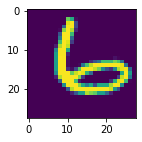

In [155]:
image_id = 3
plt.figure(figsize = (2,2))
plt.imshow(images[image_id,].reshape(28,28))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


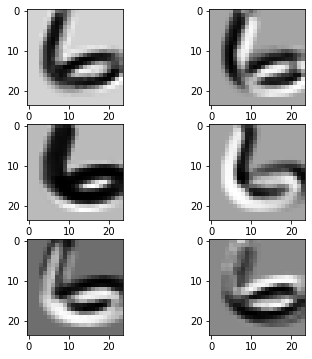

In [156]:
plt.figure(figsize = (6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1,)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")                #This is another way of pritning grey-scale images.
plt.show()

The above outputs are pretty amazing , right? 


Each i_th plot is the i_th channel output of the first Convolutional layer, after applying the activation function. **(i.e. Tanh())**

In [157]:
out=net.cnn_net[3](net.cnn_net[0](images))
out.shape

torch.Size([128, 16, 20, 20])

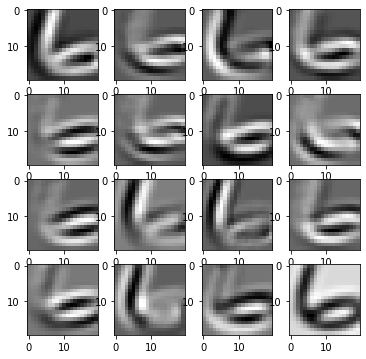

In [158]:
plt.figure(figsize = (6,6))
plt.subplot(321)
for i in range(16):
    ax1 = plt.subplot(4, 4, i+1,)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")                #This is another way of pritning grey-scale images.
plt.show()

Again, These above plots are ouputs of the 2nd convolutional layer.
